In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! unzip drive/MyDrive/brain_tumor_kaggle/rsna-miccai-brain-tumor-radiogenomic-classification/data.zip  -d brain_tumor

Streaming output truncated to the last 5000 lines.
  inflating: brain_tumor/data/train/00416/T2w/Image-34.png  
  inflating: brain_tumor/__MACOSX/data/train/00416/T2w/._Image-34.png  
  inflating: brain_tumor/data/train/00416/T2w/Image-20.png  
  inflating: brain_tumor/__MACOSX/data/train/00416/T2w/._Image-20.png  
  inflating: brain_tumor/data/train/00416/T2w/Image-21.png  
  inflating: brain_tumor/__MACOSX/data/train/00416/T2w/._Image-21.png  
  inflating: brain_tumor/data/train/00416/T2w/Image-35.png  
  inflating: brain_tumor/__MACOSX/data/train/00416/T2w/._Image-35.png  
  inflating: brain_tumor/data/train/00416/T2w/Image-10.png  
  inflating: brain_tumor/__MACOSX/data/train/00416/T2w/._Image-10.png  
  inflating: brain_tumor/data/train/00416/T2w/Image-38.png  
  inflating: brain_tumor/__MACOSX/data/train/00416/T2w/._Image-38.png  
  inflating: brain_tumor/data/train/00416/T2w/Image-39.png  
  inflating: brain_tumor/__MACOSX/data/train/00416/T2w/._Image-39.png  
  inflating: brain

In [4]:
! cp drive/MyDrive/brain_tumor_kaggle/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv brain_tumor/data/

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct 12 22:16:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# % cd drive/MyDrive/brain_tumor_kaggle
! cd brain_tumor

In [5]:
! pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D
# import sys
# sys.path.append("../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D")
from efficientnet_pytorch_3d import EfficientNet3D

  Cloning https://github.com/shijianjian/EfficientNet-PyTorch-3D to /tmp/pip-req-build-9qlhbw7o
  Running command git clone -q https://github.com/shijianjian/EfficientNet-PyTorch-3D /tmp/pip-req-build-9qlhbw7o


In [ ]:
# ! git clone https://github.com/asvcode/fmi.git

In [ ]:
# ! pip install --upgrade fastai

In [ ]:
# from fmi.fmi.explore import *
# from fmi.fmi.preprocessing import *
# from fmi.fmi.pipeline import *

In [9]:
# from fastai.vision.all import *
# from fastai.medical.imaging import *
# import pydicom
import torch
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import glob
import os
from skimage import exposure
import gc
from sklearn.metrics import roc_auc_score
from scipy import sparse


from PIL import Image
import numpy as np
import pandas as pd
import cv2

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['image.cmap'] = 'gist_ncar'

In [8]:
!ls

brain_tumor  drive  sample_data


In [10]:
# path = 'rsna-miccai-brain-tumor-radiogenomic-classification/'
# labels = pd.read_csv(f'{path}/train_labels.csv')

path = 'brain_tumor/data/'
labels = pd.read_csv(path + "train_labels.csv")

## Upload Data

In [11]:
# def dicom2array(path, voi_lut=True, fix_monochrome=True):
#     dicom = pydicom.read_file(path)
#     # VOI LUT (if available by DICOM device) is used to
#     # transform raw DICOM data to "human-friendly" view
#     if voi_lut:
#         data = apply_voi_lut(dicom.pixel_array, dicom)
#     else:
#         data = dicom.pixel_array
#     # depending on this value, X-ray may look inverted - fix that:
#     if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
#         data = np.amax(data) - data
#     data = data - np.min(data)
#     data = data / np.max(data)
#     data = (data * 255).astype(np.uint8)
#     data = cv2.resize(data, (256, 256))
#     return data

def load_images(path):
    im_frame =  cv2.imread(path, 0)
    img =  cv2.resize(im_frame, (IM_SIZE, IM_SIZE))
    return img

def get_subset(image_list, image_count):
    slice_count = image_count//2
    middle_image = len(image_list) // 2
    p1 = max(middle_image - slice_count, 0)
    p2 = middle_image + slice_count
    return p1, p2


def load_3d_png_images(scan_id, split = "train", image_count = 64):
    """
    we will use some heuristics to choose the slices to avoid any numpy zero matrix (if possible)
    """
    flair = sorted(glob.glob(f"{path}/{split}/{scan_id}/FLAIR/*.png"))
    t1w = sorted(glob.glob(f"{path}/{split}/{scan_id}/T1w/*.png"))
    t1wce = sorted(glob.glob(f"{path}/{split}/{scan_id}/T1wCE/*.png"))
    t2w = sorted(glob.glob(f"{path}/{split}/{scan_id}/T2w/*.png"))
    

    p1, p2 = get_subset(flair, image_count)
    flair_img = np.array([load_images(a) for a in flair[p1:p2]]).T
    if flair_img.shape[-1] < image_count:
        n_zero = image_count - flair_img.shape[-1]
        if n_zero == image_count:
            flair_img = np.zeros((IM_SIZE, IM_SIZE, n_zero))
        else:
            flair_img = np.concatenate((flair_img, np.zeros((IM_SIZE, IM_SIZE, n_zero))), axis = -1)
        
    p1, p2 = get_subset(t1w, image_count)
    t1w_img = np.array([load_images(a) for a in t1w[p1:p2]]).T
    if t1w_img.shape[-1] < image_count:
        n_zero = image_count - t1w_img.shape[-1]
        if n_zero == image_count:
            t1w_img = np.zeros((IM_SIZE, IM_SIZE, n_zero))
        else:
            t1w_img = np.concatenate((t1w_img, np.zeros((IM_SIZE, IM_SIZE, n_zero))), axis = -1)
    
    p1, p2 = get_subset(t1wce, image_count)
    t1wce_img = np.array([load_images(a) for a in t1wce[p1:p2]]).T
    if t1wce_img.shape[-1] < image_count:
        n_zero = image_count - t1wce_img.shape[-1]
        if n_zero == image_count:
            t1wce_img = np.zeros((IM_SIZE, IM_SIZE, n_zero))
        else:
            t1wce_img = np.concatenate((t1wce_img, np.zeros((IM_SIZE, IM_SIZE, n_zero))), axis = -1)
    
    p1, p2 = get_subset(t2w, image_count)
    t2w_img = np.array([load_images(a) for a in t2w[p1:p2]]).T
    if t2w_img.shape[-1] < image_count:
        n_zero = image_count - t2w_img.shape[-1]
        if n_zero == image_count:
            t2w_img = np.zeros((IM_SIZE, IM_SIZE, n_zero))
        else:
            t2w_img = np.concatenate((t2w_img, np.zeros((IM_SIZE, IM_SIZE, n_zero))), axis = -1)

    image_3d = np.stack((flair_img, t1w_img, t1wce_img, t2w_img), )
    image_3d = torch.tensor(image_3d, dtype=torch.float32)
    image_3d = image_3d.permute(0, 3, 2, 1) # Channel, Timestamp, Height, Width
    # image_3d = image_3d.permute(3, 0, 2, 1) # Timestamp, Channel, Height, Width

    return image_3d


In [12]:
IM_SIZE = 256

In [12]:
sample = load_3d_png_images(scan_id='00044')

In [ ]:
def show_images(images) -> None:
    images = images.cpu()
    # images = images.permute(1,0,2,3)
    n: int = len(images)
    # Per timestep
    for i in range(n):
        image_list = len(images[i])
        f = plt.figure(figsize=(10,20))
        print(f"\nChannel {i}")
        for j in range(image_list):
            # Debug, plot figure
            f.add_subplot(20, 200/20, j + 1)
            plt.imshow(images[i][j])
            plt.axis("off")
        plt.show(block=True)


Channel 0


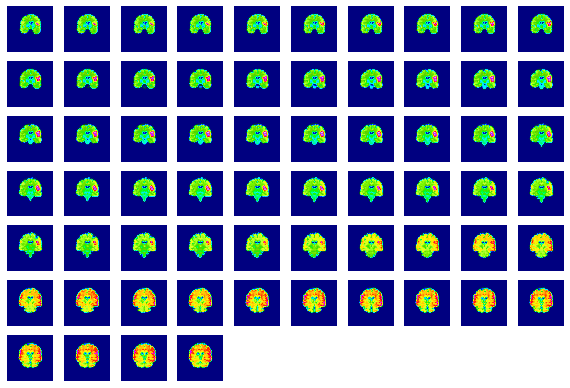


Channel 1


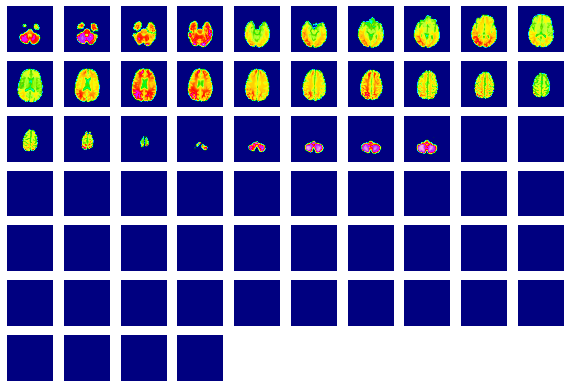


Channel 2


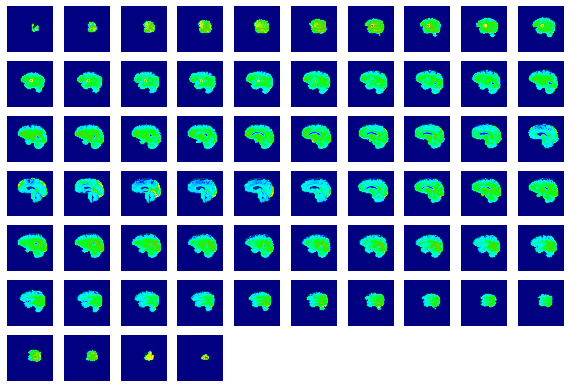


Channel 3


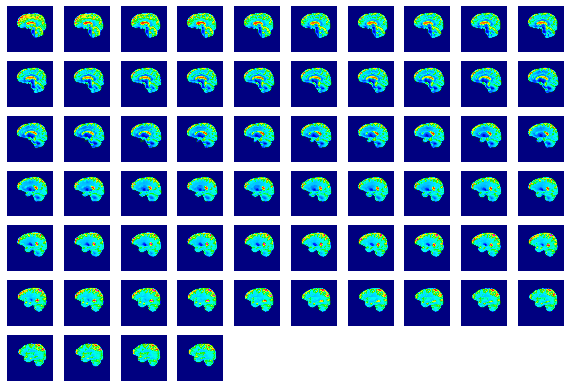

In [ ]:
show_images(sample)

## Normalizing with MCLAHE

In [14]:
! pip install --upgrade https://github.com/VincentStimper/mclahe/archive/numpy.zip

     \ 7.5 MB 821 kB/s
  Created wheel for mclahe: filename=mclahe-1.0-py2.py3-none-any.whl size=8125 sha256=22f0ee93bf49c87be9c250849e52877996f62698d9b8fd81744250a25085774f
  Stored in directory: /tmp/pip-ephem-wheel-cache-usgwnyzq/wheels/12/cd/dc/afa1d1082c77eb8ae98fc5fe4440775b88b9c0f090fd3539ce
Successfully built mclahe


In [7]:
import mclahe as mc

def clahe_3d(voxel):
    voxel = mc.mclahe(voxel, kernel_size=[8,32,32],
              n_bins=128,
              clip_limit=0.01,
              adaptive_hist_range=False)
    return (voxel*255.).astype(np.uint8).clip(0, 255)/255

In [28]:
np.ndarray.flatten(clahe_3d(sample[0].numpy())).std()

0.20019955116772525

In [31]:
(np.ndarray.flatten(sample[0].numpy())/255).std()

0.17712688

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7dbabca190>]],
      dtype=object)

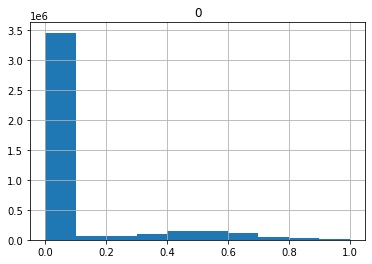

In [23]:
pd.DataFrame(np.ndarray.flatten(clahe_3d(sample[0].numpy()))).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7dba5c98d0>]],
      dtype=object)

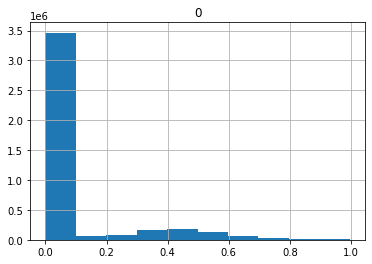

In [26]:
pd.DataFrame(np.ndarray.flatten(sample[0].numpy())/255).hist()

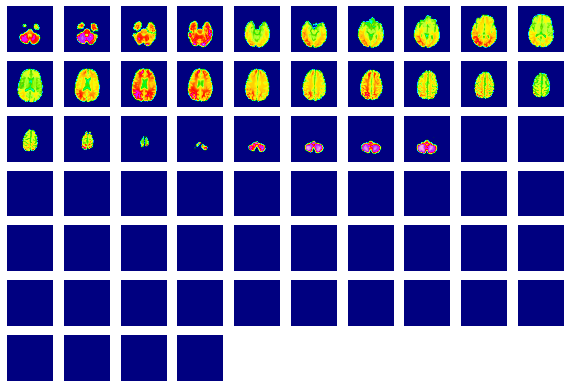

In [ ]:
show_images(sample[1])

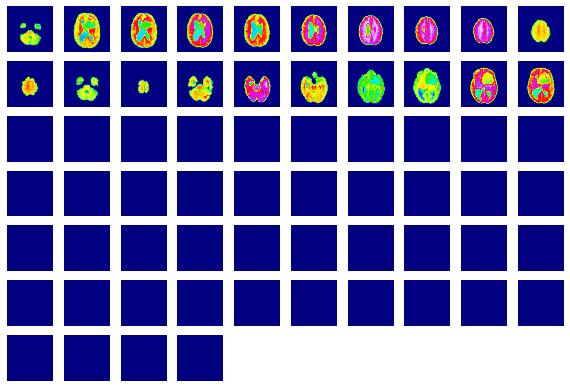

In [ ]:
show_images(train_dataset[0][0][2])

## Data Loader

In [78]:
# train_labels = pd.read_csv(f'{path}/train_labels.csv')

class BrainTumor(Dataset):
    def __init__(self, path = path, split = "train", validation_split = 0.15):
        
        # labels
        train_data = pd.read_csv(os.path.join(path, 'train_labels.csv'))
        self.labels = {}
        self.cache = {}
        self.channels = 4
        self.time = 64
        self.height = 256
        self.width = 256
        brats = list(train_data["BraTS21ID"])
        mgmt = list(train_data["MGMT_value"])
        for b, m in zip(brats, mgmt):
            self.labels[str(b).zfill(5)] = m
            
        if split == "valid":
            self.split = "train"
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob(path + f"/train/" + "/*"))]
            self.ids = self.ids[:int(len(self.ids)* validation_split)] # first 20% as validation
        elif split == "train":
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob(path + f"/train/" + "/*"))]
            self.ids = self.ids[int(len(self.ids)* validation_split):] # last 80% as train
        else:
            self.split = split
            self.ids = [a.split("/")[-1] for a in sorted(glob.glob(path + f"/{split}/" + "/*"))]
            
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):

        if not idx in self.cache:
              imgs = load_3d_png_images(self.ids[idx], self.split)

              for channel in range(len(imgs)):
                  imgs[channel] = torch.from_numpy(clahe_3d(imgs[channel].numpy()))

              imgs_cache = imgs.reshape(shape=(self.channels * self.time * self.height, self.width))
              imgs_cache = sparse.csc_matrix(imgs_cache)
              self.cache[idx] = imgs_cache
        else:
            imgs = self.cache.get(idx)
            imgs = torch.tensor(imgs.todense()).reshape(shape=(self.channels, self.time, self.height, self.width))

        # Basic pixel normalization between [0, 1]
        # imgs = imgs / 255
        
        # means = imgs.mean([1,2,3])
        # stds = torch.maximum(imgs.std([1,2,3]), torch.tensor([1]))
        # transform = transforms.Compose([transforms.Normalize(means, stds)])

        # imgs = transform(imgs.permute(1,0,2,3)).permute(1,0,2,3)

        
        if self.split != "test":
            label = self.labels[self.ids[idx]]
            return imgs, torch.tensor(label, dtype = torch.long)
        else:
            return imgs, self.ids[idx]

In [ ]:
# for i, (img, label) in enumerate(train_loader):
#     print(i)
#     print(img.shape)
#     print(label.shape)
#     break

# # for img, label in val_loader:
# #     print(img.shape)
# #     print(label.shape)
# #     break

In [ ]:
# for img, label in train_loader:
#     print(img.shape)
#     print(img.max())
#     print(img.mean())
#     print(img.min())
#     print(label.shape)
#     break

# for img, label in val_loader:
#     print(img.shape)
#     print(label.shape)
#     break

In [ ]:
# train_features, train_labels = next(iter(train_loader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")

# Modeling

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [80]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv3d(4, 8, kernel_size=(1,16,16), stride=(1,2,2))
        self.conv2 = nn.Conv3d(8, 16, kernel_size=(1,8,8))
        self.conv3 = nn.Conv3d(16, 32, kernel_size=(1,4,4), stride=(1,2,2))
        self.conv4 = nn.Conv3d(32, 64, kernel_size=(3,3,3), stride=(3,3,3))
        self.conv2_drop = nn.Dropout3d(p=0.2)
        self.conv3_drop = nn.Dropout3d(p=0.2)
        self.conv4_drop = nn.Dropout3d(p=0.2)
        self.fc1 = nn.Linear(in_features=4096, out_features=1024)
        self.fc_drop = nn.Dropout(p=0.4)
        # self.fc2 = nn.Linear(8192, 4096)
        # self.fc3 = nn.Linear(4096, 4096)
        # self.fc2 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)

        self.fc4 = nn.Linear(128, 2)

    def forward(self, x, display=False):
        if display: print(f"Input ---> {x.shape}")
        
        x = self.conv1(x)
        if display: print(f"Conv1 ---> {x.shape}")
        x = F.relu(F.max_pool3d(x, 2))
        if display: print(f"MaxPool+Relu ---> {x.shape}\n")
        
        x = self.conv2_drop(self.conv2(x))
        if display: print(f"Conv2+Dropout ---> {x.shape}")
        x = F.relu(F.max_pool3d(x, 2))
        if display: print(f"MaxPool+Relu ---> {x.shape}\n")

        x = self.conv3_drop(self.conv3(x))
        if display: print(f"Conv3+Dropout ---> {x.shape}")
        x = F.relu(x)
        if display: print(f"Relu ---> {x.shape}\n")

        x = self.conv4_drop(self.conv4(x))
        if display: print(f"Conv4+Dropout ---> {x.shape}")
        x = F.relu(x)
        if display: print(f"Relu ---> {x.shape}\n")

        # x = torch.flatten(x)
        x = x.view(-1, 4096)
        x = F.relu(self.fc_drop(self.fc1(x)))
        if display: print(f"FC1 ---> {x.shape}")
        
        x = F.relu(self.fc2(x))
        if display: print(f"FC2 ---> {x.shape}")

        x = F.relu(self.fc3(x))
        if display: print(f"FC3 ---> {x.shape}")

        x = F.relu(self.fc4(x))
        if display: print(f"FC4 ---> {x.shape}")

        # x = F.relu(self.fc5(x))
        # if display: print(f"FC5 ---> {x.shape}")

        # x = F.relu(self.fc6(x))
        # if display: print(f"FC6 ---> {x.shape}")

        # x = F.relu(self.fc7(x))
        # if display: print(f"FC7 ---> {x.shape}")

        return F.log_softmax(x, dim=-1)

        # x = x.view(-1, 676)
        # print(f"Reshape ---> {x.shape}")
        # x = F.relu(self.fc1(x))
        # print(f"FC1 ---> {x.shape}")
        # x = F.dropout(x, training=self.training)
        # x = self.fc2(x)
        # print(f"Final ---> {x.shape}")
        # return F.log_softmax(x, dim=1)
        # return x

In [81]:
class EfficientNetModel(nn.Module):
    def __init__(self):
        super(EfficientNetModel, self).__init__()
        self.model = EfficientNet3D.from_name("efficientnet-b4", override_params={'num_classes': 2, 'image_size': [64,256,256]}, in_channels=4)

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

In [98]:
class EfficientNetModelPreTrained(nn.Module):
    def __init__(self):
        super(EfficientNetModelPreTrained, self).__init__()
        self.model = EfficientNet3D.from_name("efficientnet-b1", override_params={'num_classes': 2, 'image_size': [64,256,256]}, in_channels=4)
        
        for param in self.model.parameters():
            param.requires_grad = False

        self.model._fc = nn.Sequential(nn.Linear(self.model._fc.in_features, 512), 
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        # nn.Linear(512, 256), 
                                        # nn.ReLU(),
                                        # nn.Dropout(0.3), 
                                        # nn.Linear(256, 128), 
                                        # nn.ReLU(),
                                        # nn.Dropout(0.3), 
                                        nn.Linear(512,2))

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

In [19]:
# class Combine(nn.Module):
#     def __init__(self):
#         super(Combine, self).__init__()
#         self.cnn = CNN()
#         self.rnn = nn.LSTM(
#             input_size=4608, 
#             hidden_size=64, 
#             num_layers=2,
#             batch_first=True)
#         self.linear = nn.Linear(64,2)

#     def forward(self, x):
#         batch_size, timesteps, C, H, W = x.size()
#         # c_in = x.view(batch_size * timesteps, C, H, W)
#         # print(f"Input Shape ---> {x.shape}")
#         c_out = self.cnn(x)
#         # print(f"CNN Output ---> {c_out.shape}")
        
#         batch_size, C, timesteps, H, W = c_out.size()
#         r_in = c_out.view(batch_size, timesteps, -1)
#         # print(f"RNN Reshape ---> {r_in.shape}")
#         r_out, (h_n, h_c) = self.rnn(r_in)
#         # print(f"RNN Output ---> {r_out.shape}")
#         r_out2 = self.linear(r_out[:, -1, :])
#         # print(f"Linear ---> {r_out2.shape}")
        
#         return F.log_softmax(r_out2, dim=1)

In [97]:
import psutil
import datetime

def train(epoch):

    DATE = datetime.datetime.today().strftime("%Y-%m-%d")
    model.train()
    train_loss = 0
    correct = 0
    roc = 0
    output_all = []
    target_all = []

    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        with torch.no_grad():

            output_all.extend(torch.exp(output).tolist())
            target_all.extend(one_hot(target))

            train_loss += loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

            if (batch_idx + 1) % args.log_interval == 0:

                print("\n")

                progress = (batch_idx + 1) * args.batch_size
                total = len(train_loader.dataset)
                progress_pct = np.round((progress / len(train_loader.dataset))*100, 0)

                print(f'Train Epoch: {epoch} [ {progress}/{total} --> ({progress_pct}%)]')

                print(f"Target -> {target} \t Pred -> {pred.flatten()}")

                accuracy = 100.* correct / progress
                roc = roc_auc_score(target_all, output_all)
                print(f'Loss: {loss:.4f} \t Accuracy: {accuracy:.2f} \t ROC: {roc:.2f}')

                gc.collect()
    
    accuracy = 100.* correct / len(train_loader.dataset)
    train_loss = train_loss / len(train_loader.dataset)
    roc = roc_auc_score(target_all, output_all)

    # torch.save(model.state_dict(), f"models/efficientNet3d-{DATE}-{epoch}.pkl")
    torch.save(model.state_dict(), f"drive/MyDrive/brain_tumor_kaggle/models/cnn3d_frozen-{DATE}-{epoch}.pkl")
    return train_loss, accuracy, roc


def validate():
    
    model.eval()
    val_loss = 0
    correct = 0
    target_all = []
    output_all = []
    
    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            
            if args.cuda:
                data, target = data.cuda(), target.cuda()
              
            output = model(data)

            # print(output)

            val_loss += F.nll_loss(output, target, reduction='sum') # sum up batch loss
            
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

            target_all.extend(one_hot(target))
            output_all.extend(torch.exp(output).tolist())


        val_loss /= len(val_loader.dataset)
        accuracy = 100. * correct / len(val_loader.dataset)
        roc = roc_auc_score(target_all, output_all)
        
        print("\n")
        print(f"Target -> {target} \t Pred -> {pred.flatten()}")
        print(
            f'\nTest set: Average loss: {val_loss:.4f} \t Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy:.2f}%) \t ROC: {roc:.2f}\n'
            )
        
        print("---------------------------------------")
        print("\n\n")
      
    return val_loss, accuracy, roc


def test():
    
    model.eval()
    output_all = []
    id_all = []
    
    with torch.no_grad():
        for i, (data, id) in enumerate(test_loader):
            
            if args.cuda:
                data = data.cuda()
              
            output = model(data)
            
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability

            output_all.extend(pred.flatten().tolist())
            id_all.extend(id)
      
    return id_all, output_all

In [84]:
class Args:
    def __init__(self):
        self.cuda = True
        self.no_cuda = False
        self.seed = 1
        self.batch_size = 10
        # self.test_batch_size = 1000
        self.epochs = 10
        self.lr = 0.0005
        # self.momentum = 0.5
        self.log_interval = 5


args = Args()

args.cuda = not args.no_cuda and torch.cuda.is_available()

In [85]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [86]:
# testing the dataloader
train_dataset = BrainTumor()
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0)

val_dataset = BrainTumor(split='valid')
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0)

test_dataset = BrainTumor(split='test')
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0)

In [87]:
def one_hot(arr):
    return [[1, 0] if a_i == 0 else [0, 1] for a_i in arr]

In [101]:
from torch.optim.lr_scheduler import CyclicLR, ExponentialLR, ReduceLROnPlateau

# model = CNN()
# model = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2, 'image_size': [64,256,256]}, in_channels=4)
model = EfficientNetModelPreTrained()

if args.cuda:
    model.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.00003, betas=(0.9, 0.999))
# optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9, weight_decay=0.025)
# scheduler = CyclicLR(optimizer, base_lr=0.0000003, max_lr=0.1, step_size_up=5, mode="exp_range", gamma=0.85)
scheduler = CyclicLR(optimizer, base_lr=0.000003, max_lr=0.0003, step_size_up=5, mode="triangular2", cycle_momentum=False)
# scheduler = ExponentialLR(optimizer, gamma=0.3)
# scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)


In [ ]:
model.load_state_dict(torch.load("drive/MyDrive/brain_tumor_kaggle/models/cnn3d-2021-10-12-14.pkl"))

In [100]:
def plots(train, test, metric):
    epoch = len(train)
    indexes = [i+1 for i in range(epoch)]
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle(f'Epoch {epoch}: Train and Test {metric}')
    ax1.plot(indexes, train)
    ax2.plot(indexes, test)
    plt.show()


def plot_lr(lr):
    epoch = len(lr)
    indexes = [i+1 for i in range(epoch)]
    print("Learning Rate")
    plt.plot(indexes, lr)
    plt.show()


Learning Rate: 3e-06


Train Epoch: 0 [ 50/498 --> (10.0%)]
Target -> tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0') 	 Pred -> tensor([0, 1, 0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
Loss: 0.7239 	 Accuracy: 40.00 	 ROC: 0.41


Train Epoch: 0 [ 100/498 --> (20.0%)]
Target -> tensor([1, 1, 1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0') 	 Pred -> tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
Loss: 0.6933 	 Accuracy: 47.00 	 ROC: 0.46


Train Epoch: 0 [ 150/498 --> (30.0%)]
Target -> tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0') 	 Pred -> tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
Loss: 0.6585 	 Accuracy: 51.33 	 ROC: 0.48


Train Epoch: 0 [ 200/498 --> (40.0%)]
Target -> tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0') 	 Pred -> tensor([1, 0, 1, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Loss: 0.6738 	 Accuracy: 50.00 	 ROC: 0.48


Train Epoch: 0 [ 250/498 --> (50.0%)]
Target -> tensor([1, 0, 0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0') 	 Pred -> tens

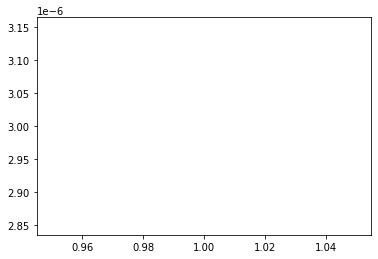

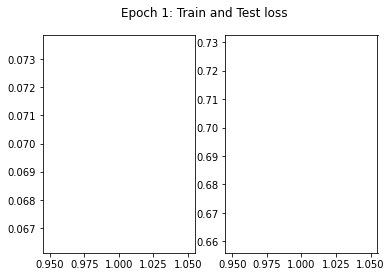

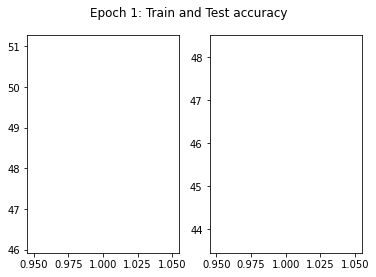

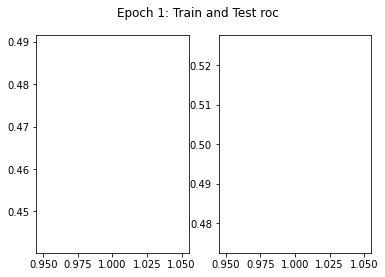

RAM memory % used: 20.7

-------------------------------------

Learning Rate: 6.240000000000004e-05


Train Epoch: 1 [ 50/498 --> (10.0%)]
Target -> tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0') 	 Pred -> tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
Loss: 0.7222 	 Accuracy: 44.00 	 ROC: 0.39


Train Epoch: 1 [ 100/498 --> (20.0%)]
Target -> tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0') 	 Pred -> tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
Loss: 0.7450 	 Accuracy: 40.00 	 ROC: 0.36


Train Epoch: 1 [ 150/498 --> (30.0%)]
Target -> tensor([1, 1, 1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0') 	 Pred -> tensor([0, 1, 0, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
Loss: 0.6908 	 Accuracy: 44.67 	 ROC: 0.42


Train Epoch: 1 [ 200/498 --> (40.0%)]
Target -> tensor([0, 0, 1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0') 	 Pred -> tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
Loss: 0.6657 	 Accuracy: 45.00 	 ROC: 0.44


Train Epoch: 1 [ 250/498 --> (50.0%)]


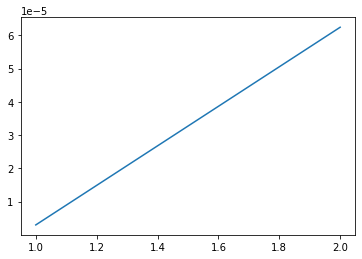

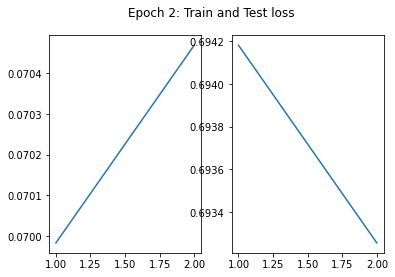

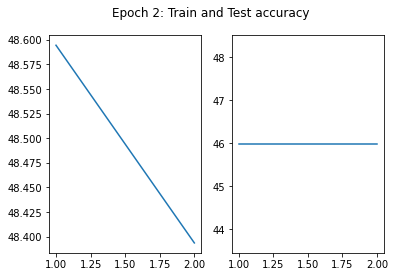

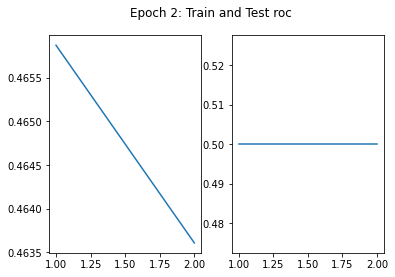

RAM memory % used: 20.7

-------------------------------------

Learning Rate: 0.00012179999999999997


Train Epoch: 2 [ 50/498 --> (10.0%)]
Target -> tensor([0, 1, 1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0') 	 Pred -> tensor([0, 1, 0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
Loss: 0.6269 	 Accuracy: 50.00 	 ROC: 0.51


Train Epoch: 2 [ 100/498 --> (20.0%)]
Target -> tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 	 Pred -> tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.6732 	 Accuracy: 54.00 	 ROC: 0.55


Train Epoch: 2 [ 150/498 --> (30.0%)]
Target -> tensor([1, 1, 0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Loss: 0.7554 	 Accuracy: 50.00 	 ROC: 0.43


Train Epoch: 2 [ 200/498 --> (40.0%)]
Target -> tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
Loss: 0.7340 	 Accuracy: 48.50 	 ROC: 0.41


Train Epoch: 2 [ 250/498 --> (50.0%)]

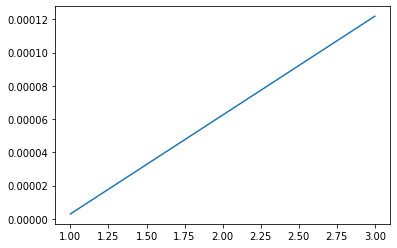

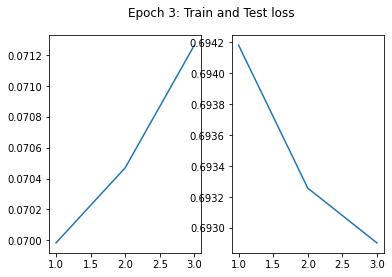

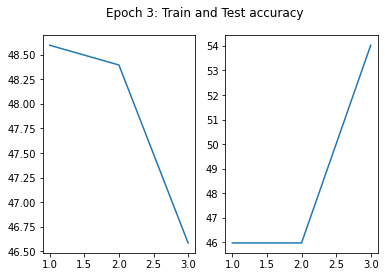

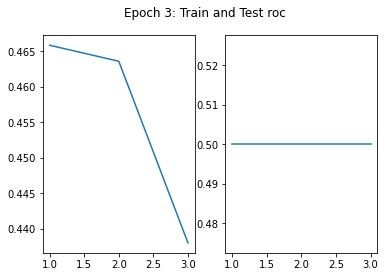

RAM memory % used: 21.0

-------------------------------------

Learning Rate: 0.00018119999999999999


Train Epoch: 3 [ 50/498 --> (10.0%)]
Target -> tensor([1, 0, 1, 1, 0, 1, 0, 0, 1, 1], device='cuda:0') 	 Pred -> tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.7021 	 Accuracy: 46.00 	 ROC: 0.44


Train Epoch: 3 [ 100/498 --> (20.0%)]
Target -> tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.5747 	 Accuracy: 58.00 	 ROC: 0.48


Train Epoch: 3 [ 150/498 --> (30.0%)]
Target -> tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 1], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.7717 	 Accuracy: 56.00 	 ROC: 0.45


Train Epoch: 3 [ 200/498 --> (40.0%)]
Target -> tensor([1, 1, 1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.7290 	 Accuracy: 54.00 	 ROC: 0.43


Train Epoch: 3 [ 250/498 --> (50.0%)]

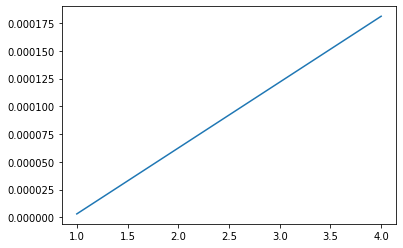

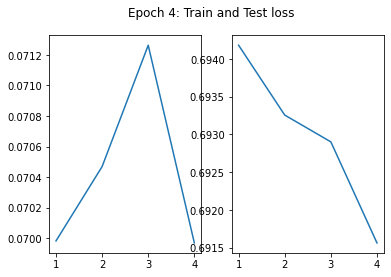

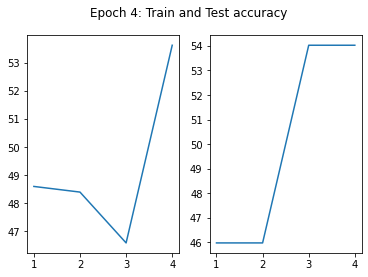

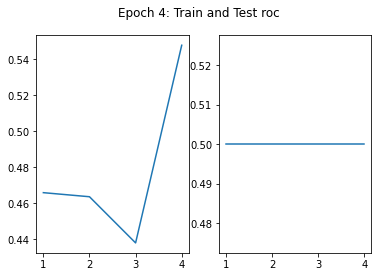

RAM memory % used: 21.5

-------------------------------------

Learning Rate: 0.0002405999999999999


Train Epoch: 4 [ 50/498 --> (10.0%)]
Target -> tensor([0, 1, 1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0') 	 Pred -> tensor([1, 0, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.7670 	 Accuracy: 48.00 	 ROC: 0.44


Train Epoch: 4 [ 100/498 --> (20.0%)]
Target -> tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0') 	 Pred -> tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Loss: 0.7462 	 Accuracy: 47.00 	 ROC: 0.44


Train Epoch: 4 [ 150/498 --> (30.0%)]
Target -> tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0') 	 Pred -> tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
Loss: 0.6832 	 Accuracy: 50.00 	 ROC: 0.45


Train Epoch: 4 [ 200/498 --> (40.0%)]
Target -> tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0') 	 Pred -> tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Loss: 0.7221 	 Accuracy: 48.00 	 ROC: 0.45


Train Epoch: 4 [ 250/498 --> (50.0%)]


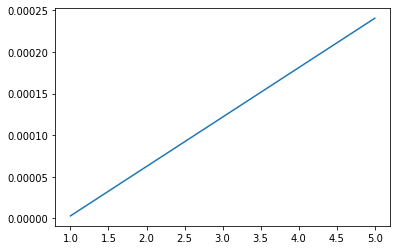

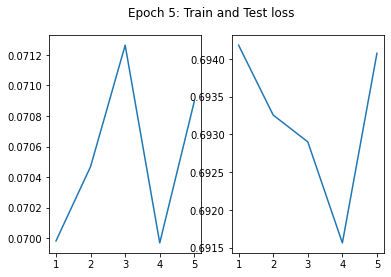

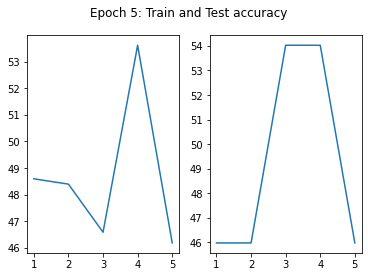

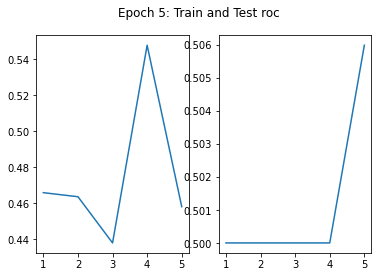

RAM memory % used: 22.5

-------------------------------------

Learning Rate: 0.0003


Train Epoch: 5 [ 50/498 --> (10.0%)]
Target -> tensor([0, 1, 0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0') 	 Pred -> tensor([1, 0, 1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
Loss: 0.8190 	 Accuracy: 48.00 	 ROC: 0.49


Train Epoch: 5 [ 100/498 --> (20.0%)]
Target -> tensor([0, 1, 1, 0, 0, 0, 1, 1, 1, 1], device='cuda:0') 	 Pred -> tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
Loss: 0.6158 	 Accuracy: 56.00 	 ROC: 0.57


Train Epoch: 5 [ 150/498 --> (30.0%)]
Target -> tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 1], device='cuda:0') 	 Pred -> tensor([0, 0, 0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
Loss: 0.7917 	 Accuracy: 52.67 	 ROC: 0.53


Train Epoch: 5 [ 200/498 --> (40.0%)]
Target -> tensor([1, 1, 0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0') 	 Pred -> tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.7205 	 Accuracy: 52.50 	 ROC: 0.53


Train Epoch: 5 [ 250/498 --> (50.0%)]
Target -> tenso

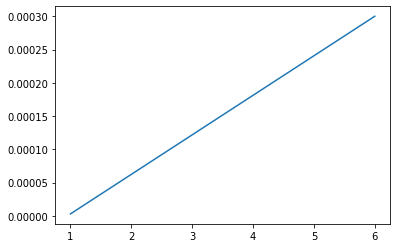

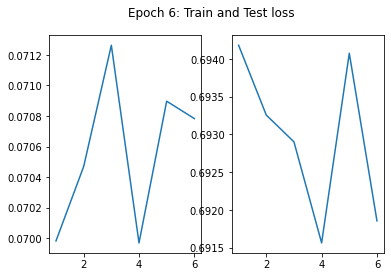

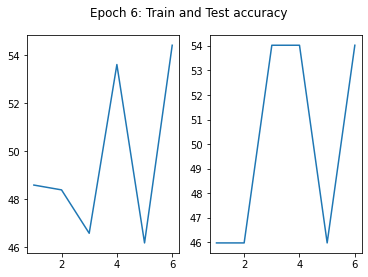

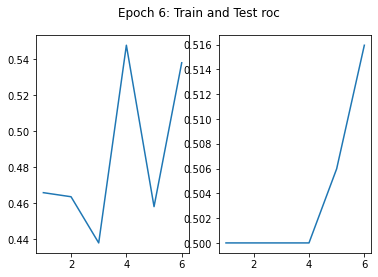

RAM memory % used: 22.5

-------------------------------------

Learning Rate: 0.0002405999999999999


Train Epoch: 6 [ 50/498 --> (10.0%)]
Target -> tensor([0, 1, 0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0') 	 Pred -> tensor([1, 0, 1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')
Loss: 0.7729 	 Accuracy: 36.00 	 ROC: 0.34


Train Epoch: 6 [ 100/498 --> (20.0%)]
Target -> tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0') 	 Pred -> tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.7286 	 Accuracy: 46.00 	 ROC: 0.47


Train Epoch: 6 [ 150/498 --> (30.0%)]
Target -> tensor([0, 0, 1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
Loss: 0.6435 	 Accuracy: 48.67 	 ROC: 0.49


Train Epoch: 6 [ 200/498 --> (40.0%)]
Target -> tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 0], device='cuda:0') 	 Pred -> tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
Loss: 0.7305 	 Accuracy: 48.00 	 ROC: 0.48


Train Epoch: 6 [ 250/498 --> (50.0%)]


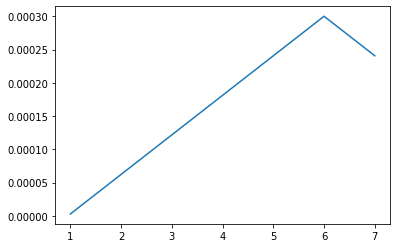

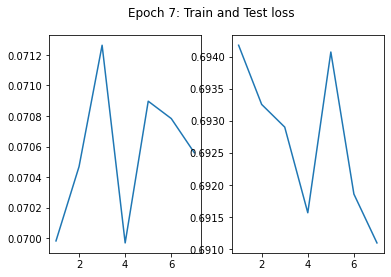

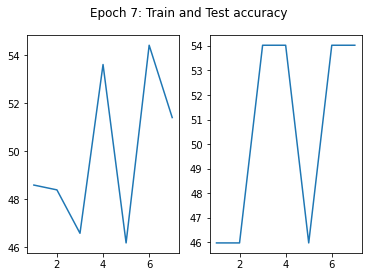

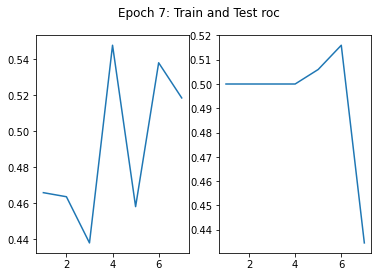

RAM memory % used: 22.5

-------------------------------------

Learning Rate: 0.00018119999999999999


Train Epoch: 7 [ 50/498 --> (10.0%)]
Target -> tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 0], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
Loss: 0.7430 	 Accuracy: 60.00 	 ROC: 0.53


Train Epoch: 7 [ 100/498 --> (20.0%)]
Target -> tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
Loss: 0.8217 	 Accuracy: 61.00 	 ROC: 0.53


Train Epoch: 7 [ 150/498 --> (30.0%)]
Target -> tensor([1, 0, 0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.6791 	 Accuracy: 59.33 	 ROC: 0.54


Train Epoch: 7 [ 200/498 --> (40.0%)]
Target -> tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
Loss: 0.6726 	 Accuracy: 57.00 	 ROC: 0.54


Train Epoch: 7 [ 250/498 --> (50.0%)]

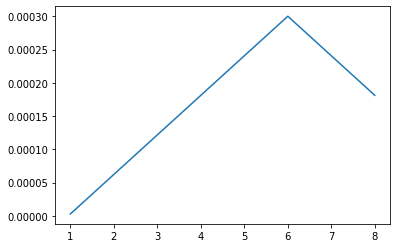

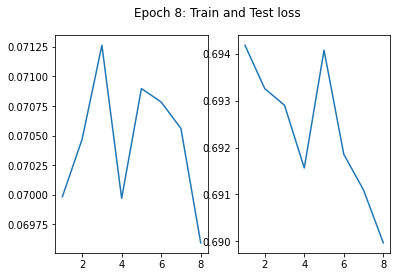

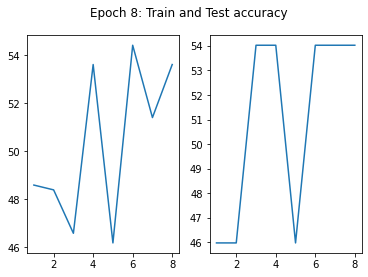

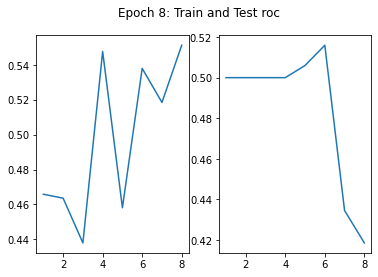

RAM memory % used: 22.5

-------------------------------------

Learning Rate: 0.00012179999999999997


Train Epoch: 8 [ 50/498 --> (10.0%)]
Target -> tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.6303 	 Accuracy: 62.00 	 ROC: 0.68


Train Epoch: 8 [ 100/498 --> (20.0%)]
Target -> tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0') 	 Pred -> tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.6294 	 Accuracy: 57.00 	 ROC: 0.61


Train Epoch: 8 [ 150/498 --> (30.0%)]
Target -> tensor([1, 1, 0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0') 	 Pred -> tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
Loss: 0.6815 	 Accuracy: 60.00 	 ROC: 0.62


Train Epoch: 8 [ 200/498 --> (40.0%)]
Target -> tensor([1, 0, 1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Loss: 0.6089 	 Accuracy: 59.00 	 ROC: 0.63


Train Epoch: 8 [ 250/498 --> (50.0%)]

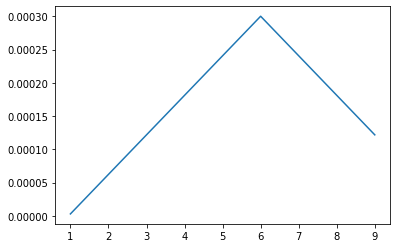

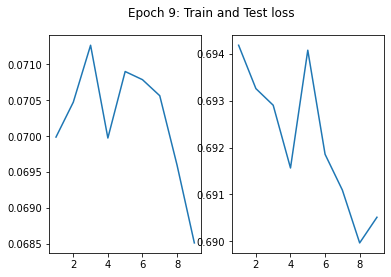

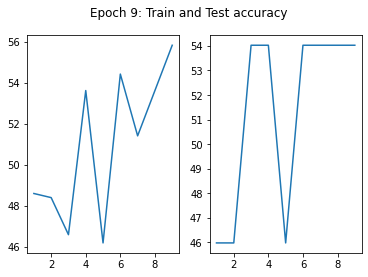

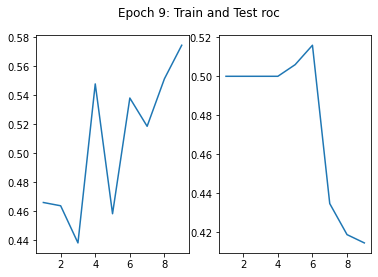

RAM memory % used: 22.6

-------------------------------------

Learning Rate: 6.240000000000004e-05


Train Epoch: 9 [ 50/498 --> (10.0%)]
Target -> tensor([1, 0, 1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0') 	 Pred -> tensor([0, 1, 0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
Loss: 0.7261 	 Accuracy: 42.00 	 ROC: 0.52


Train Epoch: 9 [ 100/498 --> (20.0%)]
Target -> tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0') 	 Pred -> tensor([0, 1, 0, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
Loss: 0.7957 	 Accuracy: 45.00 	 ROC: 0.48


Train Epoch: 9 [ 150/498 --> (30.0%)]
Target -> tensor([0, 0, 0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0') 	 Pred -> tensor([0, 0, 0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
Loss: 0.6184 	 Accuracy: 48.00 	 ROC: 0.54


Train Epoch: 9 [ 200/498 --> (40.0%)]
Target -> tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
Loss: 0.8017 	 Accuracy: 50.00 	 ROC: 0.52


Train Epoch: 9 [ 250/498 --> (50.0%)]


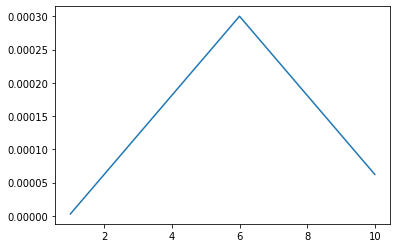

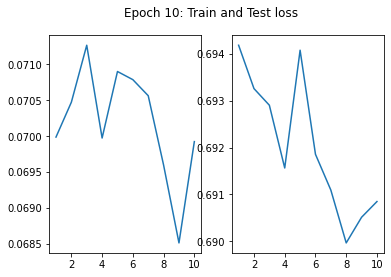

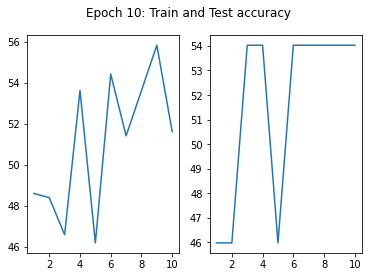

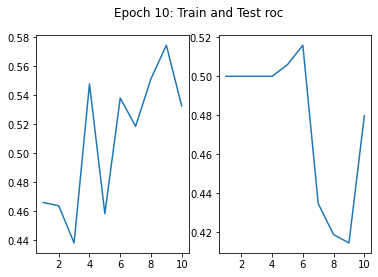

RAM memory % used: 22.6

-------------------------------------

Learning Rate: 3e-06


Train Epoch: 10 [ 50/498 --> (10.0%)]
Target -> tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0') 	 Pred -> tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.6542 	 Accuracy: 50.00 	 ROC: 0.45


Train Epoch: 10 [ 100/498 --> (20.0%)]
Target -> tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.6685 	 Accuracy: 52.00 	 ROC: 0.50


Train Epoch: 10 [ 150/498 --> (30.0%)]
Target -> tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0') 	 Pred -> tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
Loss: 0.6853 	 Accuracy: 53.33 	 ROC: 0.51


Train Epoch: 10 [ 200/498 --> (40.0%)]
Target -> tensor([1, 0, 1, 1, 0, 1, 1, 0, 0, 0], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.6997 	 Accuracy: 55.00 	 ROC: 0.49


Train Epoch: 10 [ 250/498 --> (50.0%)]
Target -> t

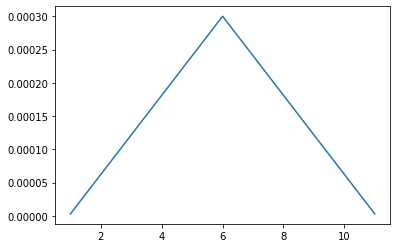

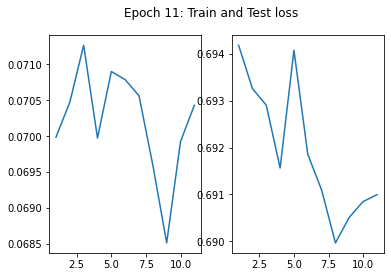

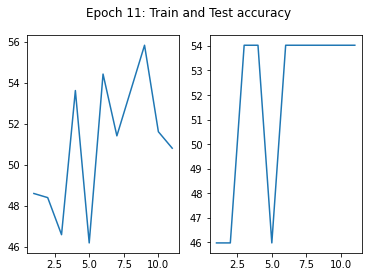

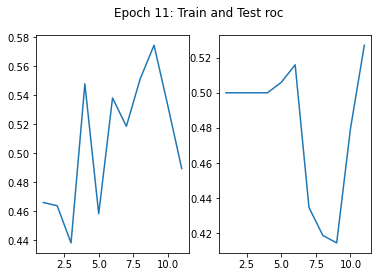

RAM memory % used: 22.6

-------------------------------------

Learning Rate: 3.270000000000002e-05


Train Epoch: 11 [ 50/498 --> (10.0%)]
Target -> tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0') 	 Pred -> tensor([0, 0, 1, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
Loss: 0.6601 	 Accuracy: 56.00 	 ROC: 0.54


Train Epoch: 11 [ 100/498 --> (20.0%)]
Target -> tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0')
Loss: 0.7247 	 Accuracy: 57.00 	 ROC: 0.50


Train Epoch: 11 [ 150/498 --> (30.0%)]
Target -> tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.7228 	 Accuracy: 54.67 	 ROC: 0.51


Train Epoch: 11 [ 200/498 --> (40.0%)]
Target -> tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 0], device='cuda:0') 	 Pred -> tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
Loss: 0.6624 	 Accuracy: 55.50 	 ROC: 0.53


Train Epoch: 11 [ 250/498 --> (50.

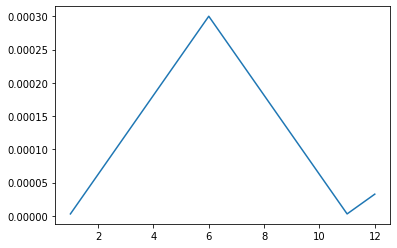

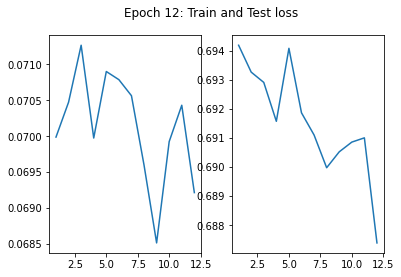

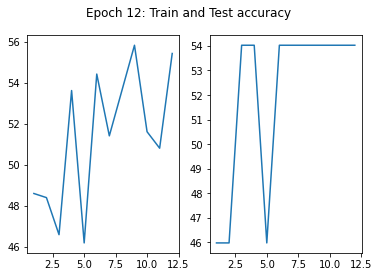

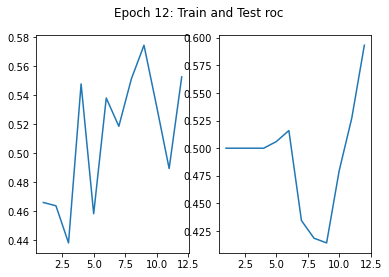

RAM memory % used: 22.6

-------------------------------------

Learning Rate: 6.240000000000004e-05


Train Epoch: 12 [ 50/498 --> (10.0%)]
Target -> tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0') 	 Pred -> tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
Loss: 0.7053 	 Accuracy: 44.00 	 ROC: 0.41


Train Epoch: 12 [ 100/498 --> (20.0%)]
Target -> tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0') 	 Pred -> tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.6421 	 Accuracy: 55.00 	 ROC: 0.49


Train Epoch: 12 [ 150/498 --> (30.0%)]
Target -> tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 1], device='cuda:0') 	 Pred -> tensor([1, 0, 1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
Loss: 0.6427 	 Accuracy: 56.00 	 ROC: 0.51


Train Epoch: 12 [ 200/498 --> (40.0%)]
Target -> tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 1], device='cuda:0') 	 Pred -> tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
Loss: 0.6657 	 Accuracy: 57.50 	 ROC: 0.55


Train Epoch: 12 [ 250/498 --> (50.

In [ ]:
train_losses = []
val_losses = []

train_accuracy = []
val_accuracy = []

train_roc = []
val_roc = []

lr_array = []

for epoch in range(25):
    lr = optimizer.param_groups[0]['lr']
    lr_array.append(lr)

    print(f"Learning Rate: {lr}")

    train_l, train_acc, train_r = train(epoch)
    train_losses.append(train_l)
    train_accuracy.append(train_acc)
    train_roc.append(train_r)

    val_l, val_acc, val_r = validate()
    val_losses.append(val_l)
    val_accuracy.append(val_acc)
    val_roc.append(val_r)

    scheduler.step()
    plot_lr(lr_array)
    plots(train_losses, val_losses, "loss")
    plots(train_accuracy, val_accuracy, "accuracy")
    plots(train_roc, val_roc, "roc")
    
    torch.cuda.empty_cache()
    gc.collect()
    print('RAM memory % used:', psutil.virtual_memory()[2])
    print('\n-------------------------------------\n')

In [108]:
  print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 59.4


In [52]:
ids, pred = test()
final_submission = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": pred})

DATE = datetime.datetime.today().strftime("%Y-%m-%d")
final_submission.sort_values(["BraTS21ID"]).to_csv(f"drive/MyDrive/brain_tumor_kaggle/results/submission_cnn-{DATE}.csv", index=False)

In [ ]:
final = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": pred})

In [ ]:
final.sort_values(["BraTS21ID"])

,BraTS21ID,MGMT_value
56,00001,1
22,00013,1
12,00015,1
45,00027,1
30,00037,1
...,...,...
81,00826,1
72,00829,1
49,00833,1
2,00997,1


## Diagnosis

In [ ]:
def load_sample():
    samples = ["00040", "00060"]
    data = []
    for sample in samples:
        imgs = load_3d_png_images(sample, "train")
              
        # means = imgs.mean([1,2,3])
        # stds = torch.maximum(imgs.std([1,2,3]), torch.tensor([1]))
        # transform = transforms.Compose([transforms.Normalize(means, stds)])

        # imgs = transform(imgs.permute(1,0,2,3)).permute(1,0,2,3)
        imgs = imgs / 255

        data.append(imgs)
    return torch.stack(data, axis=0)

In [ ]:
data = load_sample()

In [ ]:
data = data.cuda()

In [ ]:
net=EfficientNetModelPreTrained()
net=net.cuda()
output = net(data)

In [ ]:
true = [0,1]
def one_hot(arr):
    return [[1, 0] if a_i == 0 else [0, 1] for a_i in arr]

In [ ]:
output_p = torch.exp(output).cpu()

In [ ]:
with torch.no_grad():
    print(roc_auc_score(one_hot(true), output_p))

1.0


In [ ]:
data = load_sample()

In [ ]:
def show_images(images) -> None:
    images = images.cpu()
    # images = images.permute(1,0,2,3)
    n: int = len(images)
    # Per Channel
    for i in range(n):
        image_list = len(images[i])
        f = plt.figure(figsize=(10,20))
        print(f"\nChannel {i}")
        for j in range(image_list):
            # Debug, plot figure
            f.add_subplot(20, 200/20, j + 1)
            plt.imshow(images[i][j])
            plt.axis("off")
        plt.show(block=True)

In [ ]:
data = load_sample()
# model = CNN()
# model(data)

In [ ]:
model = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2, 'image_size': [64,256,256]}, in_channels=4)

In [ ]:
model(data)

tensor([[-0.0331, -3.4254],
        [-4.3258, -0.0133]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [ ]:
val, tar = next(iter(val_loader))

In [ ]:
model(val.cuda())

tensor([[-0.9937, -0.4623],
        [-0.8847, -0.5324],
        [-2.6591, -0.0726],
        [-0.4690, -0.9825],
        [-0.9076, -0.5167],
        [-0.4837, -0.9583],
        [-0.8821, -0.5343],
        [-0.0632, -2.7935],
        [-0.7259, -0.6614],
        [-0.4892, -0.9496]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [ ]:
tar

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [ ]:
data = data.cuda()

In [ ]:
net = EfficientNet3D.from_name("efficientnet-b1", override_params={'num_classes': 2, 'image_size': [64,256,256]}, in_channels=4)

In [ ]:
from torchsummary import summary
net=model.cuda()
summary(net, input_size=(4,64,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1      [-1, 4, 65, 257, 257]               0
Conv3dStaticSamePadding-2     [-1, 32, 32, 128, 128]           3,456
       BatchNorm3d-3     [-1, 32, 32, 128, 128]              64
MemoryEfficientSwish-4     [-1, 32, 32, 128, 128]               0
         ZeroPad2d-5     [-1, 32, 33, 129, 129]               0
Conv3dStaticSamePadding-6       [-1, 32, 16, 64, 64]             864
       BatchNorm3d-7       [-1, 32, 16, 64, 64]              64
MemoryEfficientSwish-8       [-1, 32, 16, 64, 64]               0
          Identity-9          [-1, 32, 1, 1, 1]               0
Conv3dStaticSamePadding-10           [-1, 8, 1, 1, 1]             264
MemoryEfficientSwish-11           [-1, 8, 1, 1, 1]               0
         Identity-12           [-1, 8, 1, 1, 1]               0
Conv3dStaticSamePadding-13          [-1, 32, 1, 1, 1]             288
         I

In [ ]:
net(data)

tensor([[ 0.0631, -0.2027],
        [-0.0124,  0.2922]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
model=CNN()
model = model.cuda()

In [ ]:
summary(model, input_size=(4,50,256,256), batch_size=2)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [2, 8, 50, 121, 121]           8,200
            Conv3d-2        [2, 16, 25, 53, 53]           8,208
         Dropout3d-3        [2, 16, 25, 53, 53]               0
            Conv3d-4        [2, 32, 12, 12, 12]           8,224
         Dropout3d-5        [2, 32, 12, 12, 12]               0
            Conv3d-6           [2, 64, 4, 4, 4]          55,360
         Dropout3d-7           [2, 64, 4, 4, 4]               0
            Linear-8                  [2, 1024]       4,195,328
           Dropout-9                  [2, 1024]               0
           Linear-10                   [2, 512]         524,800
           Linear-11                   [2, 128]          65,664
           Linear-12                     [2, 2]             258
Total params: 4,866,042
Trainable params: 4,866,042
Non-trainable params: 0
---------------------------

In [ ]:
net = net.cuda()

In [ ]:
net(data)

RuntimeError: ignored

In [ ]:
print(net)

EfficientNet3D(
  (_conv_stem): Conv3dStaticSamePadding(
    4, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock3D(
      (_depthwise_conv): Conv3dStaticSamePadding(
        32, 32, kernel_size=(3, 3, 3), stride=[2, 2, 2], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(0, 1, 0, 1, 0, 1), value=0.0)
      )
      (_bn1): BatchNorm3d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv3dStaticSamePadding(
        32, 8, kernel_size=(1, 1, 1), stride=(1, 1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv3dStaticSamePadding(
        8, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv3dStaticS

In [ ]:
test = torch.stack([sample, sample], dim=0)

In [ ]:
data.mean()

tensor(0.)

In [ ]:
sample_2 = torch.stack([sample, sample], dim=0).permute(0,2,1, 3,4)
# sample_2 = torch.stack([sample, sample], dim=0)

## normalize

In [ ]:
! pip install --upgrade https://github.com/VincentStimper/mclahe/archive/numpy.zip

     | 7.5 MB 1.3 MB/s
  Created wheel for mclahe: filename=mclahe-1.0-py2.py3-none-any.whl size=8125 sha256=1a5c6be5dd69cd4dc06a3ba8af39d6aaaeba3b470a5458d3bc47f66f974e4468
  Stored in directory: /tmp/pip-ephem-wheel-cache-178i59l2/wheels/12/cd/dc/afa1d1082c77eb8ae98fc5fe4440775b88b9c0f090fd3539ce
Successfully built mclahe


In [ ]:
import mclahe as mc

def clahe_3d(voxel):
    voxel = mc.mclahe(voxel, kernel_size=[8,32,32],
              n_bins=128,
              clip_limit=0.01,
              adaptive_hist_range=False)
    return (voxel*255.).astype(np.uint8).clip(0, 255)/255

In [ ]:
def show_images(images) -> None:
    # images = images.cpu()
    # images = images.permute(1,0,2,3)
    n: int = len(images)
    # Per Channel
    # for i in range(n):
    #     image_list = len(images[i])
    f = plt.figure(figsize=(10,20))
    for j in range(len(images)):
        # Debug, plot figure
        f.add_subplot(20, 200/20, j + 1)
        plt.imshow(images[j])
        plt.axis("off")
    plt.show(block=True)

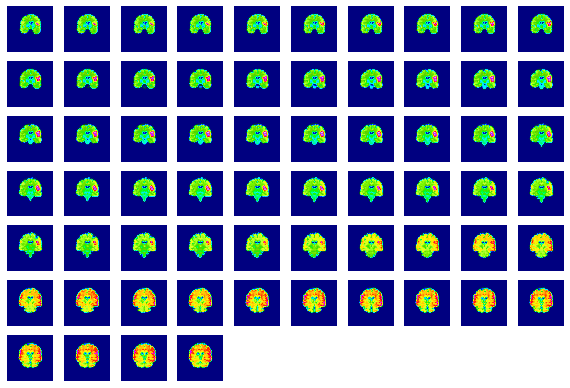

In [ ]:
show_images(sample[0])

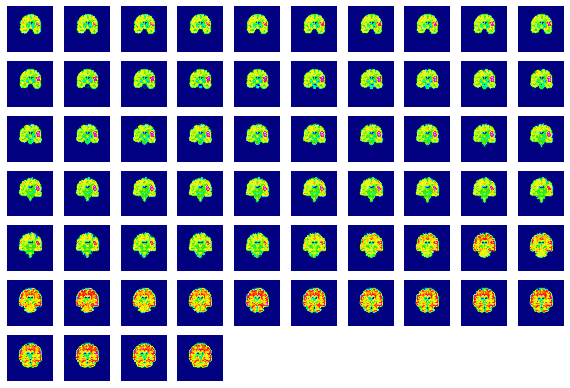

In [ ]:
show_images(clahe_3d(sample[0].numpy()))

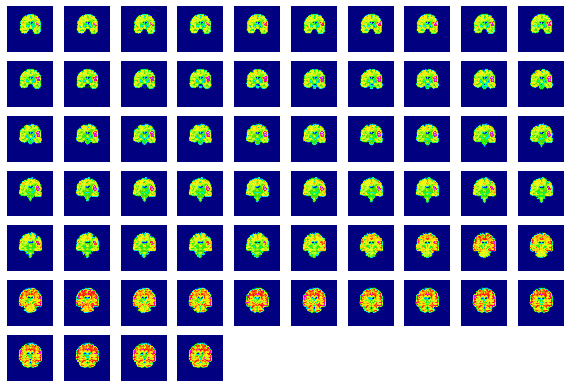

In [ ]:
show_images(clahe_3d(sample[0].numpy()))

In [ ]:
np.min(sample[0].numpy())

0.0

# FastAI

## Data Bunch